# Module: preprocessing

This module contains preprocessing functions.  Preprocessing submodules include preprocess (reshape, bin, and crap data), background (fit and subtract background), and electron_count (electron counting).

## Submodule: electron_count

The notebook demos functions related to electron counting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import py4DSTEM

from py4DSTEM.process.preprocess import electron_count

In [2]:
# Get dark reference

fp = "/home/ben/Data/20190311_Bullseye_newcamera_forElectronCounting/20190220_80kV/darkreference.h5"
darkref = py4DSTEM.file.io.read(fp)

/home/ben/Data/20190311_Bullseye_newcamera_forElectronCounting/20190220_80kV/darkreference.h5 is a py4DSTEM file, v0.3. Reading...


In [3]:
# Get data, reading from raw bit file

headersize = 4
pixelsize = 2
R_Nx,R_Ny,Q_Nx,Q_Ny = 40,40,576,576
size = np.prod((R_Nx,R_Ny,Q_Nx,Q_Ny))

fp = "/home/ben/Data/20190311_Bullseye_newcamera_forElectronCounting/20190220_80kV/scan_0000000236_logo/stem4d_0000000236_0000000000.dat"
f = open(fp, 'rb')
f.seek(headersize)
data = struct.unpack_from('<{}H'.format(size), f.read(pixelsize*size))
data = np.array(data).reshape((R_Nx,R_Ny,Q_Nx,Q_Ny))

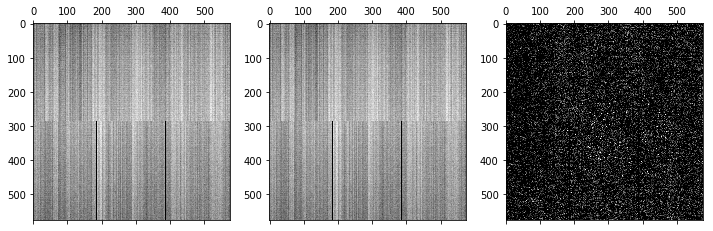

In [4]:
# Show dark reference, a raw DP, and a background subtracted DP

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,8))
ax1.matshow(darkref.data)
ax2.matshow(data[10,10,:,:])
ax3.matshow((data[10,10,:,:]-darkref.data),vmin=0,vmax=8)
plt.show()

#### Electron count

In [5]:
# Electron count
# Store output as a 4D np array of bools

Nsamples = 40
thresh_bkgrnd_Nsigma = 4
thresh_xray_Nsigma = 30
binfactor = 1
sub_pixel = False
output = 'datacube'

counted_datacube = electron_count(data, darkref.data.astype(np.int16), Nsamples=Nsamples,
                                  thresh_bkgrnd_Nsigma=thresh_bkgrnd_Nsigma,
                                  thresh_xray_Nsigma=thresh_xray_Nsigma,
                                  binfactor=binfactor,
                                  sub_pixel=sub_pixel,
                                  output=output)

Calculating threshholds
 Counting: |**************************************************| 100.0% Complete


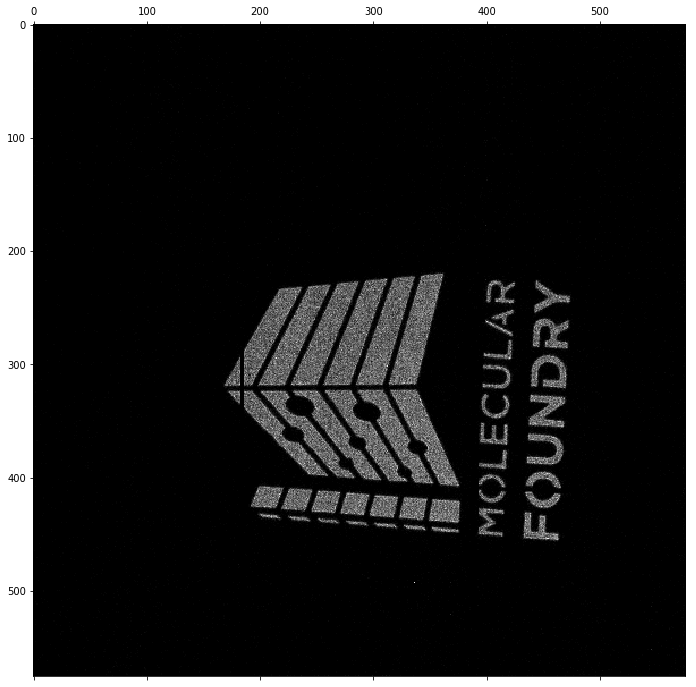

In [6]:
# Show

summed_DP = np.sum(counted_datacube,axis=(0,1))

fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(summed_DP)
plt.show()

In [7]:
# Electron count
# Store output as a PointListArray

Nsamples = 40
thresh_bkgrnd_Nsigma = 4
thresh_xray_Nsigma = 30
binfactor = 1
sub_pixel = False
output = 'pointlist'

counted_pointlistarray = electron_count(data, darkref.data.astype(np.int16), Nsamples=Nsamples,
                                        thresh_bkgrnd_Nsigma=thresh_bkgrnd_Nsigma,
                                        thresh_xray_Nsigma=thresh_xray_Nsigma,
                                        binfactor=binfactor,
                                        sub_pixel=sub_pixel,
                                        output=output)

Calculating threshholds
 Counting: |**************************************************| 100.0% Complete


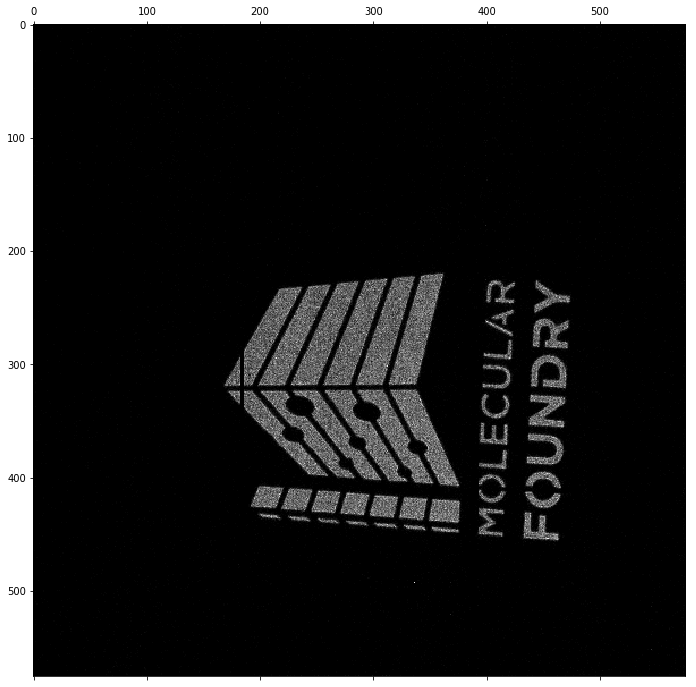

In [8]:
# Show

# Sum counted data over all scan positions
summed_DP = np.zeros((Q_Nx,Q_Ny))
for Rx in range(R_Nx):
    for Ry in range(R_Ny):
        pointlist = counted_pointlistarray.get_pointlist(Rx,Ry)
        summed_DP[pointlist.data['qx'],pointlist.data['qy']] += 1

fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(summed_DP)
plt.show()

#### Convert between pointlistarray and datacube formats

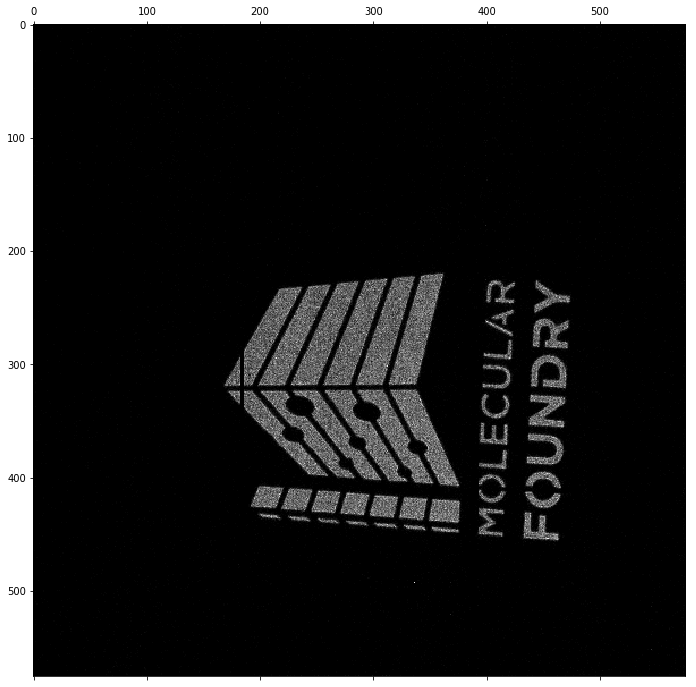

In [9]:
counted_datacube = py4DSTEM.process.preprocess.counted_pointlistarray_to_datacube(counted_pointlistarray,
                                                                                    shape=(R_Nx,R_Ny,Q_Nx,Q_Ny))

# Show
summed_DP = np.sum(counted_datacube,axis=(0,1))
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(summed_DP)
plt.show()

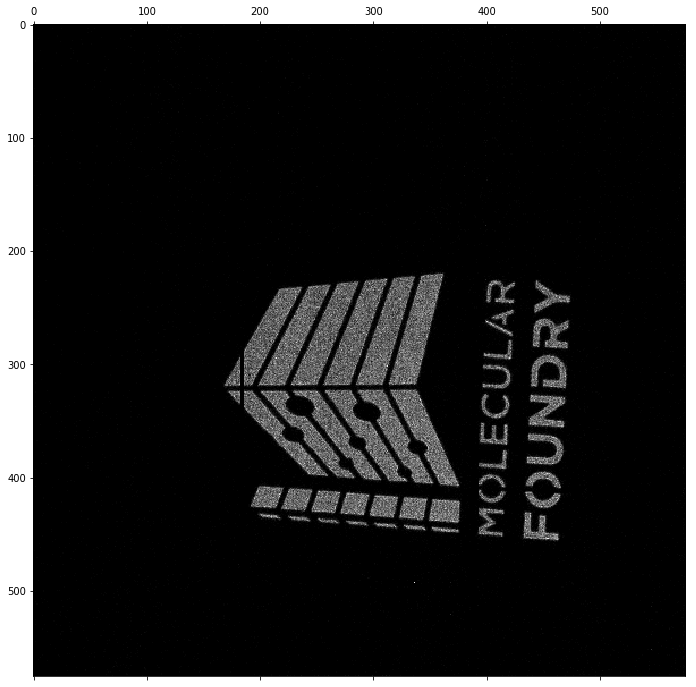

In [10]:
counted_pointlistarray = py4DSTEM.process.preprocess.counted_datacube_to_pointlistarray(counted_datacube)

# Show
summed_DP = np.zeros((Q_Nx,Q_Ny))
for Rx in range(R_Nx):
    for Ry in range(R_Ny):
        pointlist = counted_pointlistarray.get_pointlist(Rx,Ry)
        summed_DP[pointlist.data['qx'],pointlist.data['qy']] += 1
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(summed_DP)
plt.show()

In [20]:
# Saving as a PointListArray compresses the data quite a bit!

import sys

size_dc = sys.getsizeof(counted_datacube)

size_pl = 0
for Rx in range(R_Nx):
    for Ry in range(R_Ny):
        size_pl += sys.getsizeof(counted_pointlistarray.get_pointlist(Rx,Ry))

print(size_dc)
print(size_pl)
print(size_dc/size_pl)

530841744
89600
5924.573035714286
